In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pledge = 0.21  # FIL per 32GiB sector
rewards = 0.1  # FIL per 32GiB sector
basecost = 0.06  # FIL per 32GiB CC sector
ExchangeRateExposure = 1  # 1x - no exchange rate gains or losses
CostOfFilPlusRelativeToCC = 5  # 100% Fil+ has 5x larger
BorrowRate = 0.25 # 25% borrowing rate 
FractionBorrowed = 0.75 # fraction of pledge borrowed

In [3]:
# Let the multiplier be a CDM or SDM type one
def Multiplier(slope, dur, FilPlusFraction, CDM):
    if CDM == "CDM":
        return CDMMultiplier(slope, dur, FilPlusFraction)
    # capped SDM variant
    elif CDM == "CDM2":
        return CDMMultiplier2(slope, dur, FilPlusFraction)
    else:
        return SDMMultiplier(slope, dur, FilPlusFraction)
    
# The SDM multiplier has duration and Fil+ components
def SDMMultiplier(slope, dur, FilPlusFraction):
    return SDMDurMultiplier(slope, dur) * FilMultiplier(FilPlusFraction)
def SDMDurMultiplier(slope, dur):
    return 1 if dur <= 1.5 else slope * dur - 0.5 - (slope - 1) * 1.5
def FilMultiplier(FilPlusFraction):
    return 9 * FilPlusFraction + 1

# The CDM version is
def CDMMultiplier(slope, dur, FilPlusFraction):
    return min(10, max(1, dur - 1.5) * slope * (1 - FilPlusFraction + FilPlusFraction * 10))

# A capped SDM version is CDM is
def CDMMultiplier2(slope, dur, FilPlusFraction, cap=10):
    if dur <= 1.5:
        val = 1
    else:
        val = slope*dur - 0.5 - (slope - 1)*1.5
    return min(val*FilMultiplier(FilPlusFraction), cap)

# Deal rev 10% of block rewards
def DealRevenue(FilPlusFraction, RewardsPerSector):
    return 0.1 * FilPlusFraction * RewardsPerSector

# 1. A 'base level' CC operation cost
def BaseCAPEXPerYear(BaseCost, dur):
    return 0.5 * BaseCost / dur
def BaseOPEXPerYear(BaseCost):
    return 0.5 * BaseCost
def BaseCostPerYear(BaseCost, dur):
    return BaseCAPEXPerYear(BaseCost, dur) + BaseOPEXPerYear(BaseCost)

# 2. An additional cost associated with Fil+ per year compared to CC
def FILPlusCostsPerYear(BaseCost, FilPlusFraction, dur):
    return CostOfFilPlusRelativeToCC * BaseCAPEXPerYear(BaseCost, dur) * math.sin(FilPlusFraction * math.pi / 2)

# 3. Cost associated with borrowing pledge
def BorrowingCostsPerYear(BaseCost, FilPlusFraction, slope, dur, CDM, PledgePerSector):
    return FractionBorrowed * BorrowRate * PledgePerSector * Multiplier(slope, dur, FilPlusFraction, CDM)

def Costs(BaseCost, FilPlusFraction, slope, dur, CDM, PledgePerSector):
    return BaseCostPerYear(BaseCost, dur) + FILPlusCostsPerYear(BaseCost, FilPlusFraction, dur) + BorrowingCostsPerYear(BaseCost, FilPlusFraction, slope, dur, CDM, PledgePerSector)

# 1y rewards multiple
def OneYearRM(slope, dur, FilPlusFraction, BaseCost, RewardsPerSector, PledgePerSector, CDM):
    num = (ExchangeRateExposure*RewardsPerSector*Multiplier(slope, dur, FilPlusFraction, CDM) +
          DealRevenue(FilPlusFraction, RewardsPerSector) -
          Costs(BaseCost, FilPlusFraction, slope, dur, CDM, PledgePerSector))
    den = Multiplier(slope, dur, FilPlusFraction, CDM)*PledgePerSector
    return num/den

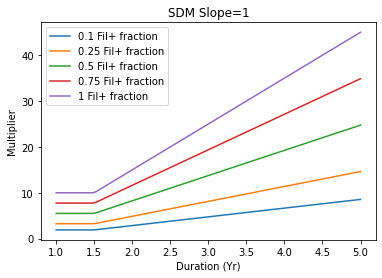

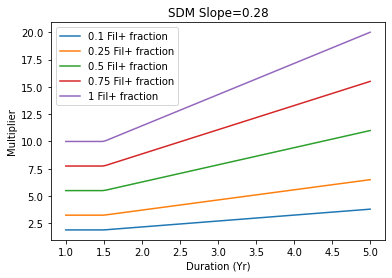

In [4]:
filfractions = [0.1, 0.25, 0.5, 0.75, 1]  # list of Fil+ fractions

# Plot the first graph for slope = 1
fig, ax = plt.subplots()
for i in range(len(filfractions)):
    ax.plot(np.linspace(1, 5, 100), [SDMMultiplier(1, dur, filfractions[i]) for dur in np.linspace(1, 5, 100)], 
            label=str(filfractions[i]) + " Fil+ fraction")
ax.set_xlabel('Duration (Yr)')
ax.set_ylabel('Multiplier')
ax.set_title('SDM Slope=1')
ax.legend()
 
# Plot the second graph for slope = 0.285
fig, ax = plt.subplots()
for i in range(len(filfractions)):
    ax.plot(np.linspace(1, 5, 100), [SDMMultiplier(2/7, dur, filfractions[i]) for dur in np.linspace(1, 5, 100)], 
            label=str(filfractions[i]) + " Fil+ fraction")
ax.set_xlabel('Duration (Yr)')
ax.set_ylabel('Multiplier')
ax.set_title('SDM Slope=0.28')
ax.legend()

plt.show()

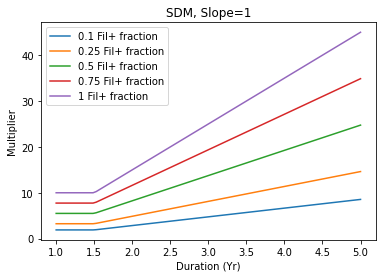

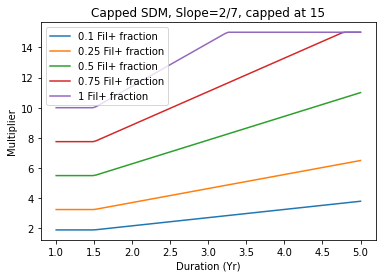

In [5]:
# Plot the SDM multipliers for slope = 1
fig, ax = plt.subplots()
for i in range(len(filfractions)):
    ax.plot(np.linspace(1, 5, 100), [SDMMultiplier(1, d, filfractions[i]) for d in np.linspace(1, 5, 100)], 
            label=str(filfractions[i]) + ' Fil+ fraction')
ax.set_xlabel('Duration (Yr)')
ax.set_ylabel('Multiplier')
ax.set_title('SDM, Slope=1')
ax.legend()
plt.show()

# Plot the CDM multipliers for slope = 2/7 and capped at 15
fig, ax = plt.subplots()
for i in range(len(filfractions)):
    ax.plot(np.linspace(1, 5, 100), [CDMMultiplier2(2/7, d, filfractions[i], 15) for d in np.linspace(1, 5, 100)], 
            label=str(filfractions[i]) + ' Fil+ fraction')
ax.set_xlabel('Duration (Yr)')
ax.set_ylabel('Multiplier')
ax.set_title('Capped SDM, Slope=2/7, capped at 15')
ax.legend()
plt.show()

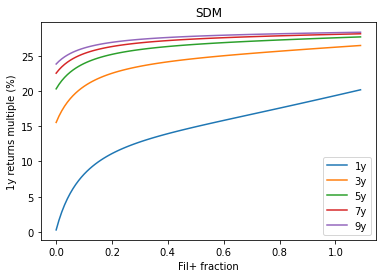

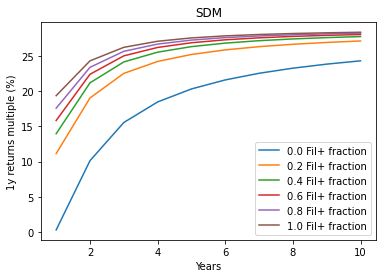

In [6]:
slope = 2/7

for year in range(1, 11, 2):
    OneYearRM_list = []
    for filfraction in np.arange(0, 1.1, 0.01):
        OneYearRM_list.append(100 * OneYearRM(slope, year, filfraction, basecost, rewards, pledge, "SDM"))
    plt.plot(np.arange(0, 1.1, 0.01), OneYearRM_list, label=str(year)+'y')

plt.xlabel('Fil+ fraction')
plt.ylabel('1y returns multiple (%)')
plt.title('SDM')
plt.legend()
plt.show()


filps = [i/5 for i in range(6)]
years = range(1, 11)

for filp in filps:
    rm_values = [100 * OneYearRM(slope, year, filp, basecost, rewards, pledge, "SDM") for year in years]
    plt.plot(years, rm_values, label=f"{filp} Fil+ fraction")

plt.xlabel("Years")
plt.ylabel("1y returns multiple (%)")
plt.title("SDM")
plt.legend()
plt.show()